In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from gpflow.utilities import print_summary, set_trainable, to_default_float
import gpflow
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions

import os
os.environ["CUDA_VISIBLE_DEVICES"] = '1'

from sklearn.metrics import mean_squared_error, mean_absolute_error

import sys
sys.path.append('../../src')
from data_preparation import get_birth_data, separate_data

In [2]:
# load data

# whole dataset
data = get_birth_data()
x, y = separate_data(data, train_test=False)

# train/test split
df_train = pd.read_csv('../../data/train.csv')
x_train, y_train = separate_data(df_train)
df_test = pd.read_csv('../../data/test.csv')
x_test, y_test = separate_data(df_test)

# get date for x-axis in plots
def get_xticks(data):
    idss = []; yrs = []
    yr = 1969
    for i in range(20):
        df = data.loc[data.year == yr+i]
        yrs.append(yr+i)
        idss.append(df.index[0])
    return idss, yrs
pos, labels = get_xticks(data)
pos_train, labels_train = get_xticks(df_train)
pos_test, labels_test = get_xticks(df_test)

2022-07-25 12:29:41.719230: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-07-25 12:29:42.288570: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9646 MB memory:  -> device: 0, name: GeForce RTX 2080 Ti, pci bus id: 0000:1b:00.0, compute capability: 7.5


# Simple one-latent function model

        y = f(x) + e
        f = GP(0, RBF)

In [3]:
# function to plot results

def plot_distribution(X, Y, mean, var, pos, labels):
    plt.figure(figsize=(25, 7))

    plt.plot(X, Y, '.', color="black", alpha=0.5, markersize=3)
    plt.plot(X, mean, color="C0")
    c = 1.96 * np.sqrt(var)
    plt.fill_between(X[:,0], (mean - c)[:,0], (mean + c)[:,0], alpha=0.2, edgecolor='gray', facecolor='C0')

    plt.xticks(pos, labels)
    plt.xlabel('Date')
    plt.ylabel('Normalised Births')
    plt.show()
    plt.close()

2022-07-25 12:29:59.436165: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
2022-07-25 12:30:04.764903: I tensorflow/core/util/cuda_solvers.cc:179] Creating GpuSolver handles for stream 0x8870050


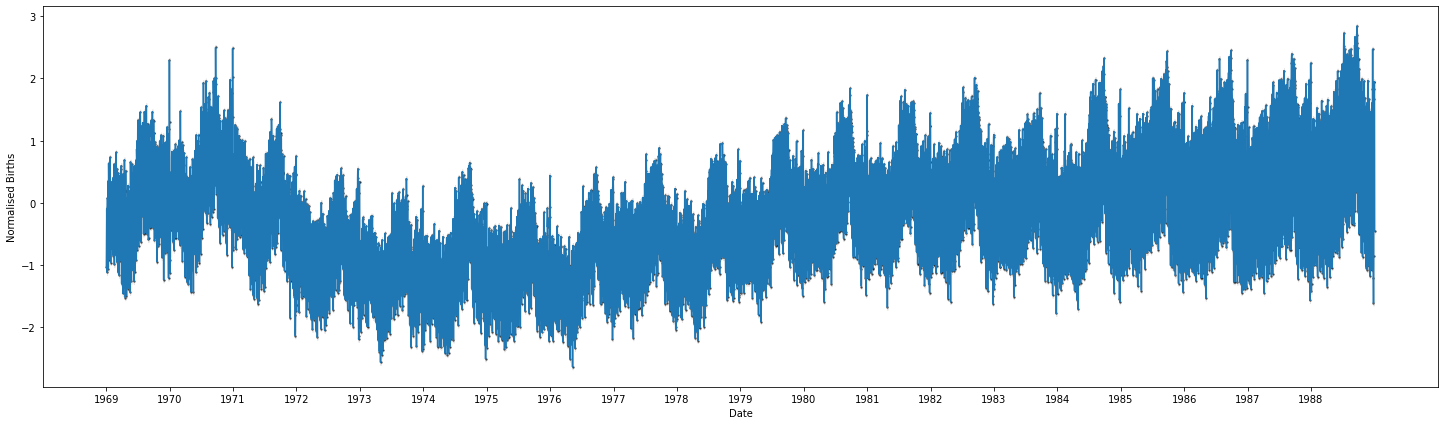

TypeError: print_summary() got an unexpected keyword argument 'format'

In [4]:
# build model & compute fitted values

kernel = gpflow.kernels.RBF() 

model = gpflow.models.GPR(data=(x, y), kernel=kernel, mean_function=None)
#set_trainable(model.likelihood.variance , False)

opt = gpflow.optimizers.Scipy()
opt_logs = opt.minimize(model.training_loss, model.trainable_variables)

mean, var = model.predict_f(x)

plot_distribution(x, y, mean, var, pos, labels)

print_summary(model, format='notebook')
model.compute_log_likelihood()

In [ ]:
# rebuild model and add priors to hyperparameters

kernel = gpflow.kernels.RBF()

model = gpflow.models.GPR(data=(x, y), kernel=kernel, mean_function=None)

# adding priors
model.kernel.variance.prior = tfp.distributions.Gamma(to_default_float(2), to_default_float(3))
model.kernel.lengthscales.prior = tfp.distributions.InverseGamma(to_default_float(2), to_default_float(3))

opt = gpflow.optimizers.Scipy()
opt_logs = opt.minimize(model.training_loss, model.trainable_variables)

mean, var = model.predict_f(x)

plot_distribution(x, y, mean, var, pos, labels)

print_summary(model, format='notebook')
model.compute_log_likelihood()

Make fitting and prediciton automatic

In [ ]:
def optimise_predict_model(model):
    opt = gpflow.optimizers.Scipy()
    opt_logs = opt.minimize(model.training_loss, model.trainable_variables)

    mean, var = model.predict_f(x)

    plot_distribution(x, y, mean, var, pos, labels)

    print_summary(model, format='notebook')
    print(model.compute_log_likelihood())


# Train / Test split: model selection

Assess which kernel helps represent the data best.

    MSE, MAE, Likelihood

In [ ]:
def optimise_predict_model(model):
    opt = gpflow.optimizers.Scipy()
    opt_logs = opt.minimize(model.training_loss, model.trainable_variables)

    mean_train, var_train = model.predict_f(x_train)
    mean_test, var_test = model.predict_f(x_test)

    plot_distribution(x_train, y_train, mean_train, var_train, pos_train, labels_train)
    plot_distribution(x_test, y_test, mean_test, var_test, pos_test, labels_test)

    print_summary(model, format='notebook')
    print('likelihood: ', model.compute_log_likelihood())
    print('train mse: ', mean_squared_error(y_train, mean_train))
    print('test mse: ', mean_squared_error(y_test, mean_test))
    print('train mse: ', mean_absolute_error(y_train, mean_train))
    print('test mse: ', mean_absolute_error(y_test, mean_test))